This tutorial can be found on the [Wallaroo Tutorials Github Repository](https://github.com/WallarooLabs/Wallaroo_Tutorials/blob/main/wallaroo-model-cookbooks/computer-vision-mitochondria-imaging).

## Image Detection for Health Care Computer Vision Tutorial Part 02: External Data Connection Stores

The first example in this tutorial series showed selecting from 10 random images of cells and detecting mitochondria from within them.

This tutorial will expand on that by using a Wallaroo connection to retrieve a high resolution 1536x2048 image, break it down into 256x256 "patches" that can be quickly analyzed.

Wallaroo connections are definitions set by MLOps engineers that are used by other Wallaroo users for connection information to a data source.  For this example, the data source will be a GitHub URL, but they could be Google BigQuery databases, Kafka topics, or any number of user defined examples.

## Tutorial Goals

This tutorial will perform the following:

1. Upload and deploy the `mitochondria_epochs_15.onnx` model to a Wallaroo pipeline.
1. Create a Wallaroo connection pointing to a location for a high resolution image of cells.
1. Break down the image into 256x256 images based on the how the model was trained to detect mitochondria.
1. Convert the images into a numpy array inserted into a pandas DataFrame.
1. Submit the DataFrame to the Wallaroo pipeline and use the results to create a mask image of where the model detects mitochondria.
1. Compare the original image against a map of "ground truth" and the model's mask image.
1. Undeploy the pipeline and return the resources back to the Wallaroo instance.

## Prerequisites

## Prerequisites

Complete the steps from Mitochondria Detection Computer Vision Tutorial Part 00: Prerequisites.

## Mitochondria Computer Vision Detection Steps

### Import Libraries

The first step is to import the necessary libraries.  Included with this tutorial are the following custom modules:

* `tiff_utils`: Organizes the tiff images to perform random image selections and other tasks.

In [1]:
import json
import IPython.display as display
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from lib.TiffImageUtils import TiffUtils
import tifffile as tiff

import pandas as pd

import wallaroo
from wallaroo.object import EntityNotFoundError, RequiredAttributeMissing

import numpy as np
from matplotlib import pyplot as plt
import cv2
from keras.utils import normalize

tiff_utils = TiffUtils()

# used for unique connection names

import string
import random

suffix= ''.join(random.choice(string.ascii_lowercase) for i in range(4))

# ignoring warnings for demonstration
import warnings
warnings.filterwarnings('ignore')

### Open a Connection to Wallaroo

The next step is connect to Wallaroo through the Wallaroo client.  The Python library is included in the Wallaroo install and available through the Jupyter Hub interface provided with your Wallaroo environment.

This is accomplished using the `wallaroo.Client()` command, which provides a URL to grant the SDK permission to your specific Wallaroo environment.  When displayed, enter the URL into a browser and confirm permissions.  Store the connection into a variable that can be referenced later.

If logging into the Wallaroo instance through the internal JupyterHub service, use `wl = wallaroo.Client()`.  If logging in externally, update the `wallarooPrefix` and `wallarooSuffix` variables with the proper DNS information.  For more information on Wallaroo DNS settings, see the [Wallaroo DNS Integration Guide](https://docs.wallaroo.ai/wallaroo-operations-guide/wallaroo-configuration/wallaroo-dns-guide/).

In [2]:
wl = wallaroo.Client()

### Create Workspace and Pipeline

We will create a workspace to manage our pipeline and models.  The following variables will set the name of our sample workspace then set it as the current workspace.

Workspace, pipeline, and model names should be unique to each Wallaroo instance, so we'll add in a randomly generated suffix so multiple people can run this tutorial in a Wallaroo instance without effecting each other.

In [3]:
workspace_name = f'biolabsconnectionworkspace{suffix}'
pipeline_name = f'biolabsconnectionpipeline{suffix}'
model_name = f'biolabsconnectionmodel{suffix}'
model_file_name = 'models/mitochondria_epochs_15.onnx'

In [4]:
def get_workspace(name):
    workspace = None
    for ws in wl.list_workspaces():
        if ws.name() == name:
            workspace= ws
    if(workspace == None):
        workspace = wl.create_workspace(name)
    return workspace

def get_pipeline(name):
    try:
        pipeline = wl.pipelines_by_name(name)[0]
    except EntityNotFoundError:
        pipeline = wl.build_pipeline(name)
    return pipeline

In [5]:
workspace = get_workspace(workspace_name)

wl.set_current_workspace(workspace)

pipeline = get_pipeline(pipeline_name)
pipeline

name,biolabsconnectionpipelinepdrv
created,2023-07-14 15:29:16.969523+00:00
last_updated,2023-07-14 15:29:16.969523+00:00
deployed,(none)
tags,
versions,79d3b6ca-823f-406d-bf23-88a23b49ff1b
steps,


### Upload the Models

Now we will:

1. Upload our model.
1. Apply it as a step in our pipeline.
1. Create a pipeline deployment with enough memory to perform the inferences.
1. Deploy the pipeline.

In [6]:
deployment_config = wallaroo.DeploymentConfigBuilder().replica_count(1).cpus(1).memory("2Gi").build()

model = (wl.upload_model(model_name, 
                         model_file_name, 
                         framework=wallaroo.framework.Framework.ONNX)
                         .configure(tensor_fields=["tensor"])
        )

pipeline = wl.build_pipeline(pipeline_name) \
            .add_model_step(model) \
            .deploy(deployment_config = deployment_config)

### Create the Wallaroo Connection

The Wallaroo connection will point to the location of our high resolution images:

* One the cell photos to be retrieved
* The other "ground truth" masks that are mapped compared against the model's predictions.

The images will be retrieved, then parsed into a series of 256x256 images.

In [9]:
image_connection_name = f'mitochondria_image_source{suffix}'
image_connection_type = "HTTP"
image_connection_argument = {
    'cell_images':'https://storage.googleapis.com/wallaroo-public-data/csa_demo/computer-vision/examples/medical/bio-labs/atl-lab/images/ms-01-atl-3-22-23_9-50.tiff',
    'ground_truth_masks': 'https://storage.googleapis.com/wallaroo-public-data/csa_demo/computer-vision/examples/medical/bio-labs/atl-lab/masks/ms-01-atl-3-22-23_9-50-masks.tiff'
    }

connection = wl.create_connection(image_connection_name, image_connection_type, image_connection_argument)

### Retrieve Images

We'll use our new connection to reach out, retrieve the images and store them locally for processing.  The information is stored in the `details()` method for the connection, which is hidden by default when showing the connection, but the data can be retrieved when necessary.

In [10]:
inference_source_connection = wl.get_connection(name=image_connection_name)
display(inference_source_connection)

Field,Value
Name,mitochondria_image_sourcepdrv
Connection Type,HTTP
Details,*****
Created At,2023-07-14T15:32:00.930954+00:00
Linked Workspaces,[]


In [11]:
patches_dict = tiff_utils.build_patches("downloaded_patches", 
                                        (256,256), 
                                        256, 
                                        inference_source_connection.details()['cell_images'], 
                                        inference_source_connection.details()['ground_truth_masks'] )

created dir downloaded_patches/ms-01-atl-3-22-23_9-50
saving file downloaded_patches/ms-01-atl-3-22-23_9-50/ms-01-atl-3-22-23_9-50.tiff


### Retrieve Image and Convert to Data

The next step is to process the image into a numpy array that the model is trained to detect from.

We start by retrieving all the patch images from a recorded time series tiff recorded on one of our microscopes.

In [12]:
sample_mitochondria_patches_path = "./downloaded_patches/ms-01-atl-3-22-23_9-50"

patches = tiff_utils.get_all_patches(sample_mitochondria_patches_path)

Randomly we will retrieve a 256x256 patch image and use it to do our semantic segmentation prediction.

We'll then convert it into a numpy array and insert into a DataFrame for a single inference.

The following helper function `loadImageAndConvertTiff` is used to convert the image into a numpy, then insert that into the DataFrame.  This allows a later command to take the randomly grabbed image perform the process on other images.

In [13]:
def loadImageAndConvertTiff(imagePath, width, height):
    img = cv2.imread(imagePath, 0)
    imgNorm = np.expand_dims(normalize(np.array(img), axis=1),2)
    imgNorm=imgNorm[:,:,0][:,:,None]
    imgNorm=np.expand_dims(imgNorm, 0)
    
    resizedImage = None
    #creates a dictionary with the wallaroo "tensor" key and the numpy ndim array representing image as the value.
    dictData = {"tensor":[imgNorm]}
    dataframedata = pd.DataFrame(dictData)
    # display(dataframedata)
    return dataframedata, resizedImage

In [14]:
def run_semantic_segmentation_inference(pipeline, input_tiff_image, width, height, threshold):
    
    tensor, resizedImage = loadImageAndConvertTiff(input_tiff_image, width, height)
    # print(tensor)

    # #
    # # run inference on the 256x256 patch image get the predicted mitochandria mask
    # #
    output = pipeline.infer(tensor)
    # print(output)

    # # Obtain the flattened predicted mitochandria mask result
    list1d = output.loc[0]["out.conv2d_37"]
    np1d = np.array(list1d)
    
    # # unflatten it
    predicted_mask = np1d.reshape(1,width,height,1)
    
    # # perform the element-wise comaprison operation using the threshold provided
    predicted_mask = (predicted_mask[0,:,:,0] > threshold).astype(np.uint8)
    
    # return predicted_mask
    return predicted_mask

### Infer and Display Results

We will now perform our inferences and display the results.  This results in a predicted mask showing us where the mitochondria cells are located.

1. The first image is the input image.
1. The 2nd image is the ground truth. The mask was created by a human who identified the mitochondria cells in the input image
1. The 3rd image is the predicted mask after running inference on the Wallaroo pipeline.

We'll perform this 10 times to show how quickly the inferences can be submitted.

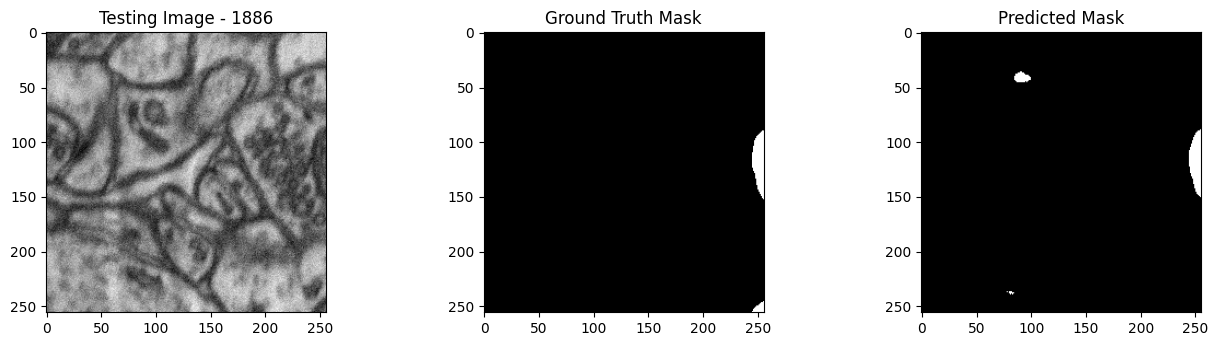

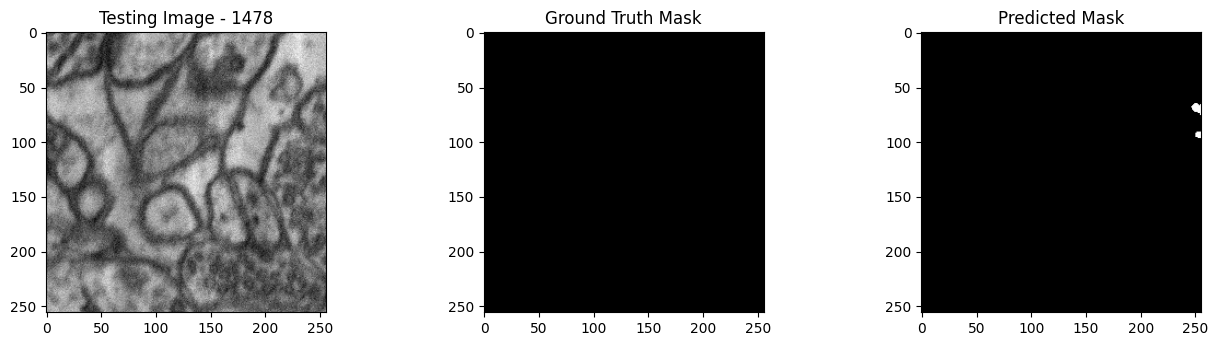

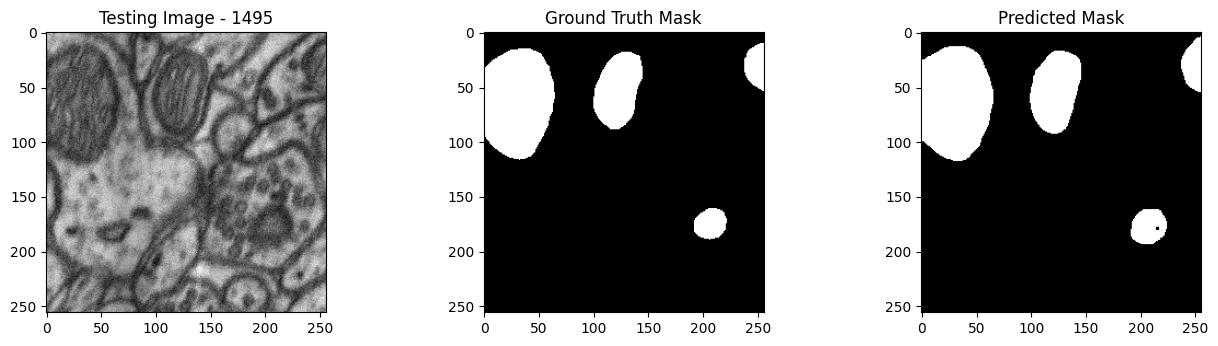

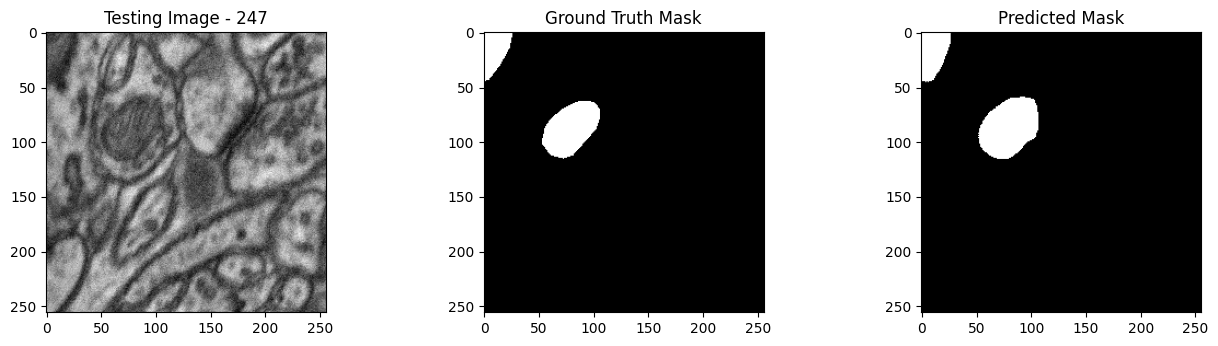

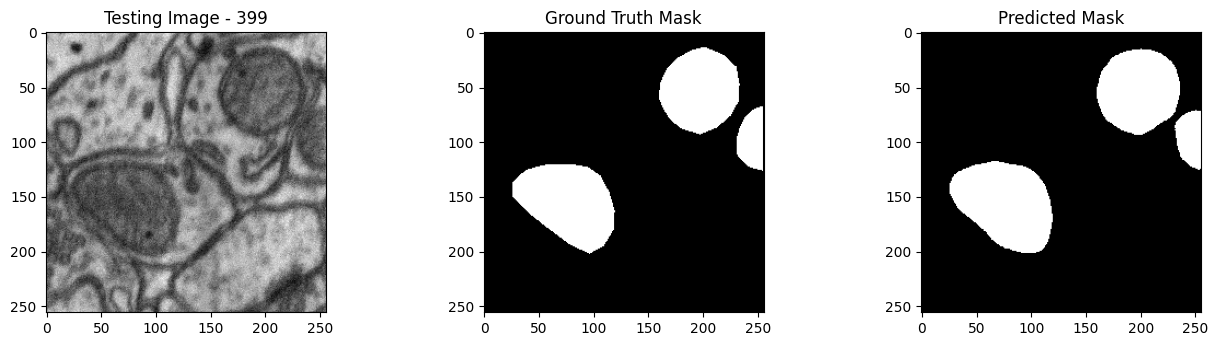

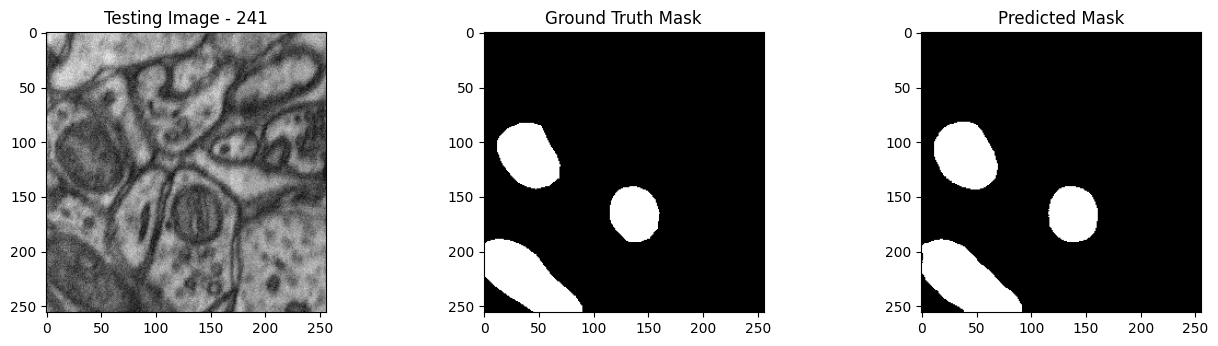

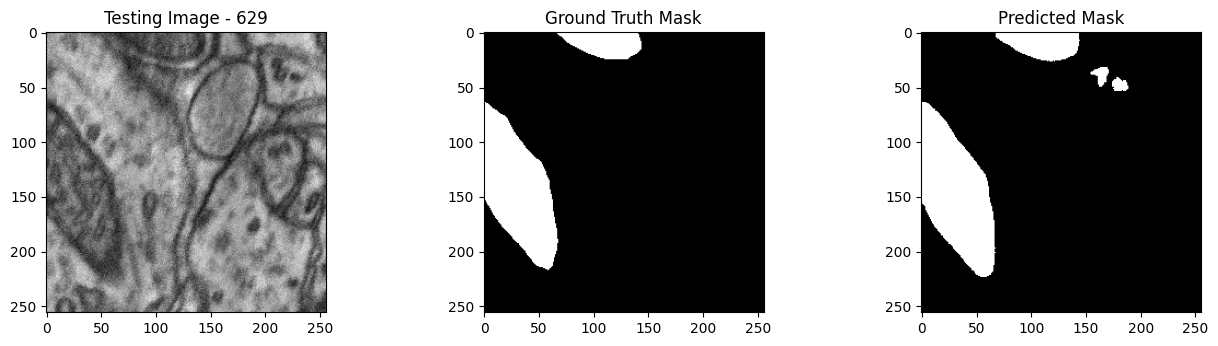

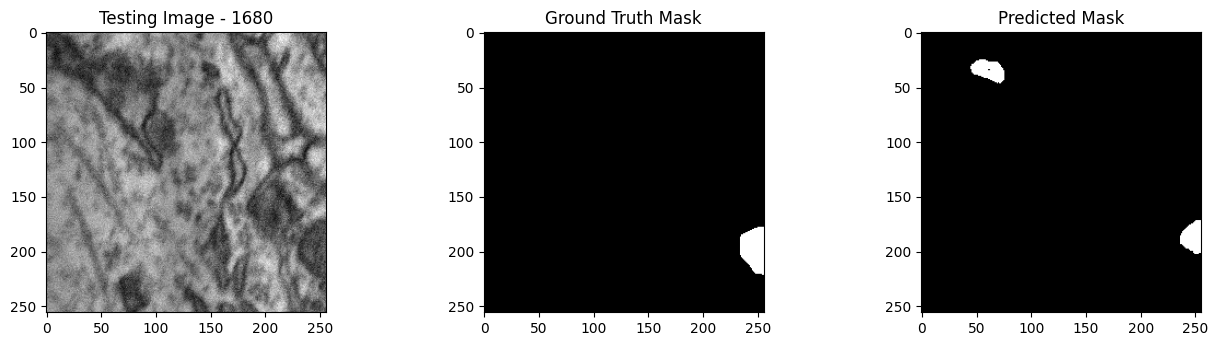

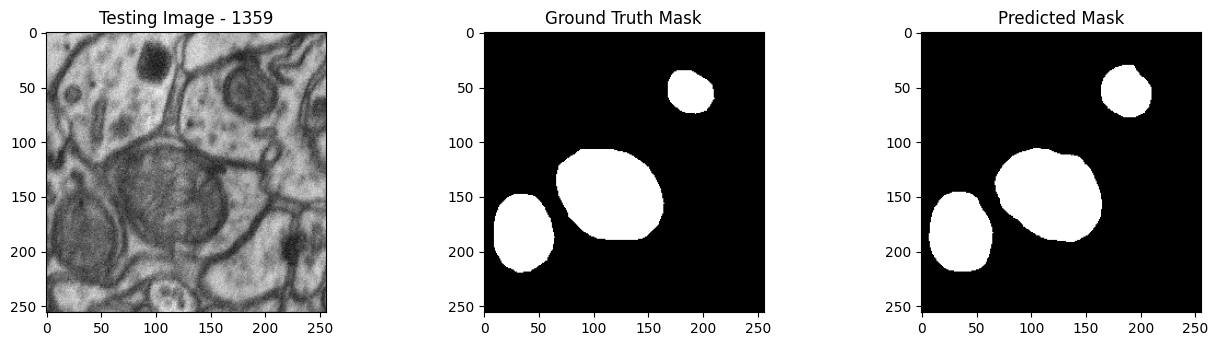

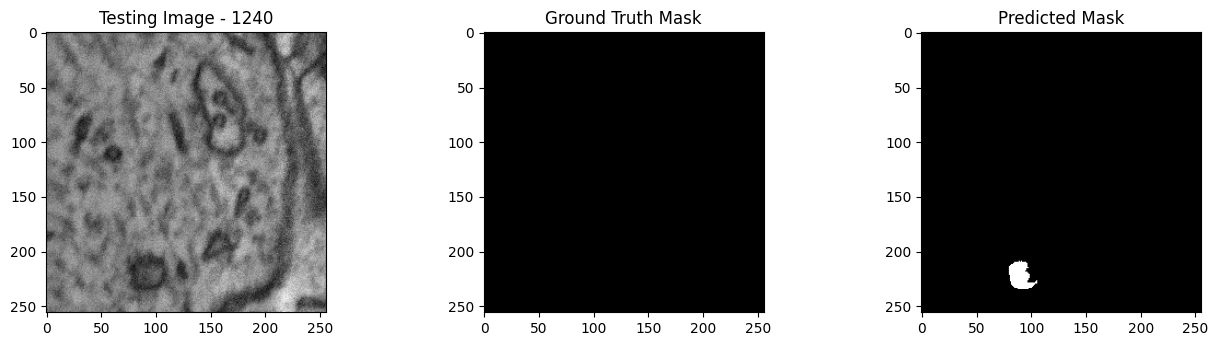

In [15]:
for x in range(10):     
    # get a sample 256x256 mitochondria image
    random_patch = tiff_utils.get_random_patch_sample(patches)

    # build the path to the image
    patch_image_path = sample_mitochondria_patches_path + "/images/" + random_patch['patch_image_file']

    # run inference in order to get the predicted 256x256 mask
    predicted_mask = run_semantic_segmentation_inference(pipeline, patch_image_path, 256,256, 0.2)

    # # plot the results
    test_image = random_patch['patch_image'][:,:,0]
    test_image_title = f"Testing Image - {random_patch['index']}"

    ground_truth_image = random_patch['patch_mask'][:,:,0]
    ground_truth_image_title = "Ground Truth Mask"

    predicted_mask_title = 'Predicted Mask'

    tiff_utils.plot_test_results(test_image, test_image_title, \
                            ground_truth_image, ground_truth_image_title, \
                            predicted_mask, predicted_mask_title)

### Complete Tutorial

With the demonstration complete, the pipeline is undeployed and the resources returned back to the Wallaroo instance.

In [17]:
pipeline.undeploy()

name,biolabsconnectionpipelinepdrv
created,2023-07-14 15:29:16.969523+00:00
last_updated,2023-07-14 15:29:23.004729+00:00
deployed,False
tags,
versions,"0daae212-f578-4723-a0e5-edbcfa548976, 143eb35c-8606-471c-8053-230640249ad6, 79d3b6ca-823f-406d-bf23-88a23b49ff1b"
steps,biolabsconnectionmodelpdrv
